# Importing libraries

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.11.0


/tmp/ipykernel_26605/3405315932.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Data extracting

In [ ]:
!mv ../data/challenges_in_representation/train ../data/
!mv ../data/challenges_in_representation/test ../data/

# Plot sample images

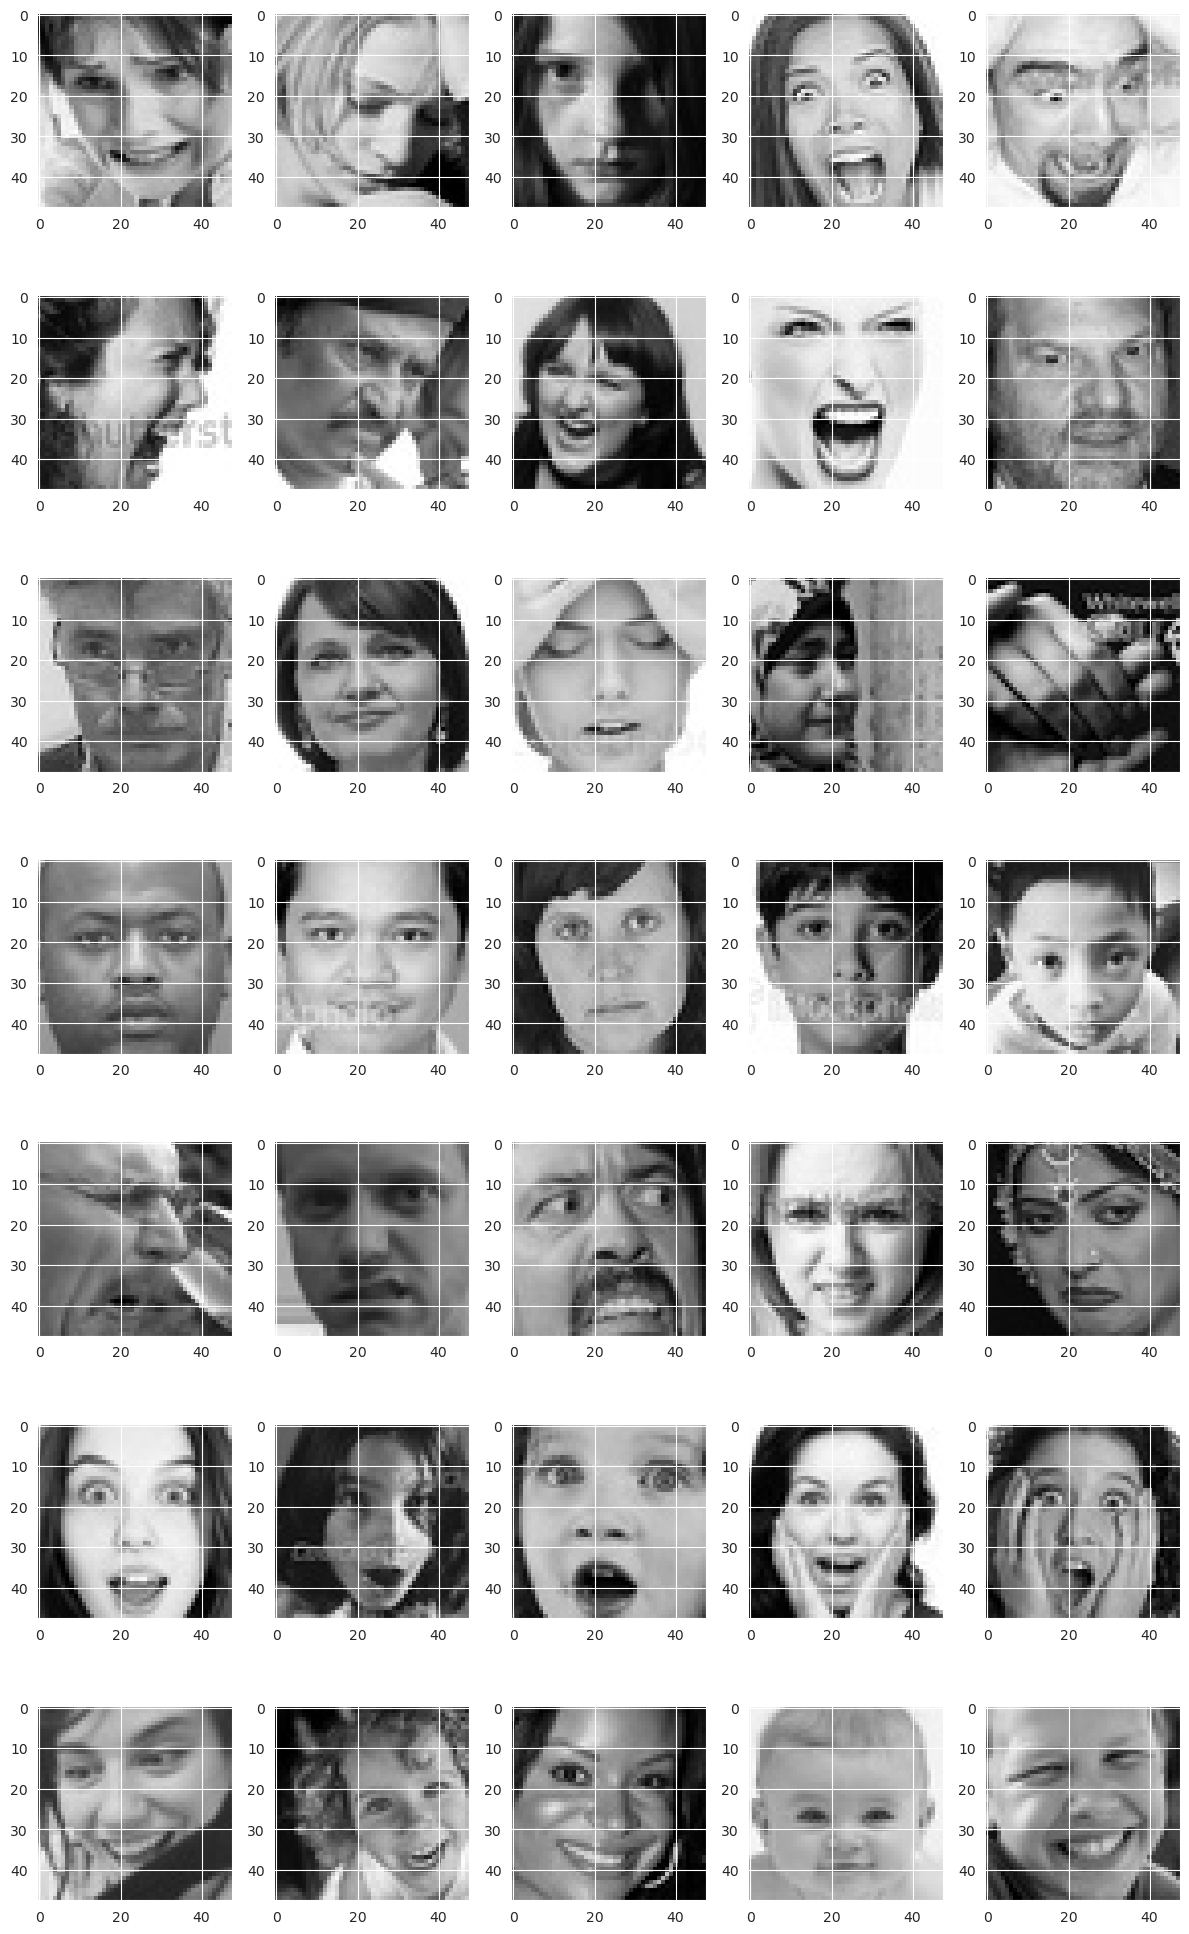

In [22]:
root_dir = "../data"

def plot_example_images():
    img_size = 48
    plt.figure(0, figsize=(12, 20))
    ctr = 0

    for expression in os.listdir(os.path.join(root_dir, "train")):
        for i, filename in enumerate(os.listdir(os.path.join(root_dir, "train", expression))[:5]):
            ctr += 1
            plt.subplot(7, 5, ctr)
            img = load_img(os.path.join(root_dir, "train", expression, filename), target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    plt.show()

plot_example_images()

# Data Distribution

In [13]:
def display_data_distribution(data_type):
    data_directory = os.path.join(root_dir, data_type)
    for expression in os.listdir(data_directory):
        expression_path = os.path.join(data_directory, expression)
        num_images = len(os.listdir(expression_path))
        print(f"{num_images} {expression} images in {data_type} folder")

In [14]:
display_data_distribution("train")

4097 fear images in train folder
3995 angry images in train folder
4830 sad images in train folder
4965 neutral images in train folder
436 disgust images in train folder
3171 surprise images in train folder
7214 happy images in train folder


In [15]:
display_data_distribution("test")

1024 fear images in test folder
958 angry images in test folder
1247 sad images in test folder
1233 neutral images in test folder
111 disgust images in test folder
831 surprise images in test folder
1774 happy images in test folder


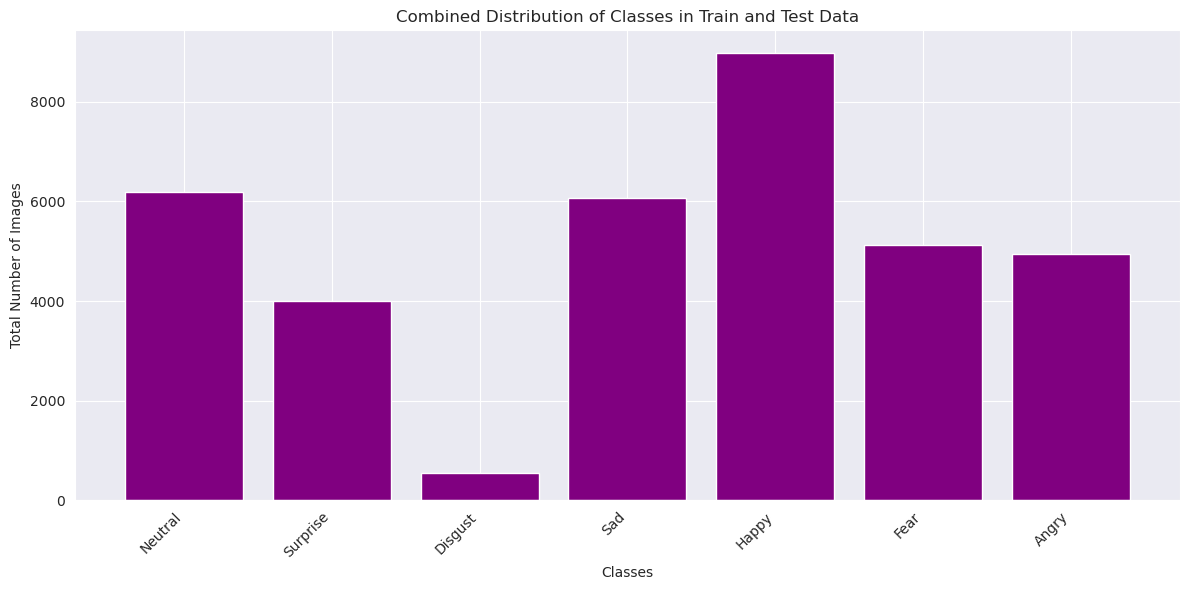

In [19]:
def plot_combined_data_distribution():
    train_directory = os.path.join(root_dir, "train")
    test_directory = os.path.join(root_dir, "test")
    train_dist = {}
    test_dist = {}

    # Calculate number of images for each class in the train directory
    for expression in os.listdir(train_directory):
        expression_path = os.path.join(train_directory, expression)
        num_images = len(os.listdir(expression_path))
        train_dist[expression.capitalize()] = num_images

    # Calculate number of images for each class in the test directory
    for expression in os.listdir(test_directory):
        expression_path = os.path.join(test_directory, expression)
        num_images = len(os.listdir(expression_path))
        test_dist[expression.capitalize()] = num_images

    # Summing the total number of images for each class across train and test directories
    combined_dist = {key: train_dist.get(key, 0) + test_dist.get(key, 0) for key in set(train_dist) | set(test_dist)}

    classes = list(combined_dist.keys())
    values = list(combined_dist.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, values, color='purple')
    plt.title("Combined Distribution of Classes in Train and Test Data")
    plt.xlabel("Classes")
    plt.ylabel("Total Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_combined_data_distribution()

# Training and validation batch

In [23]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(
    os.path.join(root_dir, "train"),
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(
    os.path.join(root_dir, "test"),
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Create CNN Model

In [25]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compiling the model
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

# Training and evaluation function

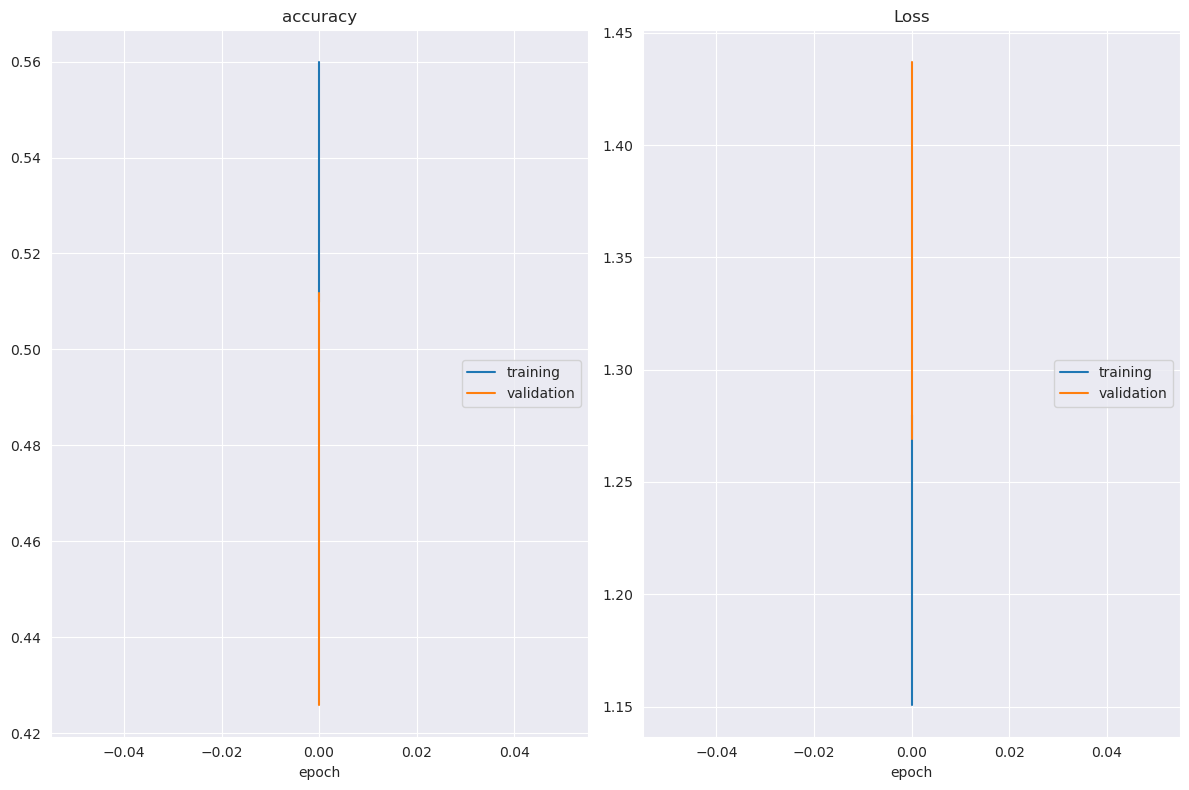

accuracy
	training         	 (min:    0.510, max:    0.560, cur:    0.560)
	validation       	 (min:    0.426, max:    0.512, cur:    0.426)
Loss
	training         	 (min:    1.151, max:    1.280, cur:    1.151)
	validation       	 (min:    1.269, max:    1.437, cur:    1.437)

Epoch 1: saving model to ../models/model_weights.h5
448/448 [==============================] - 192s 428ms/step - loss: 1.1509 - accuracy: 0.5598 - val_loss: 1.4368 - val_accuracy: 0.4259 - lr: 0.0010
CPU times: user 3h 18min 7s, sys: 7min 9s, total: 3h 25min 16s
Wall time: 9min 35s


In [31]:
%%time

epochs = 3
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("../models/model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = {} 

for epoch in tqdm(range(epochs), desc="Epoch"):
    model.fit(
        x=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
    )